In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nepsa/NepSA.csv
/kaggle/input/word2vec/__results__.html
/kaggle/input/word2vec/__notebook__.ipynb
/kaggle/input/word2vec/__output__.json
/kaggle/input/word2vec/custom.css
/kaggle/input/word2vec/output/finetuned.txt
/kaggle/input/word2vec/scratch/scratch.txt
/kaggle/input/pretrained-fasttext/pretrained_word2vec/pretrained_word2vec.txt
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors_vocab.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.vectors_ngrams_lockf.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.syn1neg.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.vectors_vocab_lockf.npy
/kaggle/input/pretrained-fasttext/pretrained_

In [2]:
# Imports
import torch 
from torch.utils.data import Dataset as torch_ds
from gensim.models import FastText, KeyedVectors
from datasets import Dataset as hf_ds, DatasetDict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path

# Output paths
hf_output = "./hf_datasets/"
torch_output = "./torch_datasets/"

Path(hf_output).mkdir()
Path(torch_output).mkdir()

# Getting csv data
df = pd.read_csv("/kaggle/input/nepsa/NepSA.csv")
df.head()

,Text,Target
0,गुठी विधेक ल्याएर ठमेल राज गुठि जग्गा छाया सेन...,0
1,दले देश सकेछन बेचे खान सुरू गरेछन दले लखेटनु पछ ।,1
2,नेपाल ससकृती ध्वस्त पार्ने योजना !,1
3,मठ मन्दिर गुम्बा जग्गा हरु भुमाफिया नजर परे हु...,1
4,नेपाल कल कर्खाना नदि नाला बेची सके मठ मन्दीर ब...,1


In [3]:
from nltk.tokenize import word_tokenize

# First checking the count of words in text
df_copy = df.copy()
df_copy["Text"] = df_copy["Text"].apply(lambda x: word_tokenize(x))

df_copy.head()

,Text,Target
0,"[गुठी, विधेक, ल्याएर, ठमेल, राज, गुठि, जग्गा, ...",0
1,"[दले, देश, सकेछन, बेचे, खान, सुरू, गरेछन, दले,...",1
2,"[नेपाल, ससकृती, ध्वस्त, पार्ने, योजना, !]",1
3,"[मठ, मन्दिर, गुम्बा, जग्गा, हरु, भुमाफिया, नजर...",1
4,"[नेपाल, कल, कर्खाना, नदि, नाला, बेची, सके, मठ,...",1


In [4]:
print(df_copy.loc[1,"Text"])

['दले', 'देश', 'सकेछन', 'बेचे', 'खान', 'सुरू', 'गरेछन', 'दले', 'लखेटनु', 'पछ', '।']


In [5]:
df_copy["Count"] = df_copy["Text"].apply(lambda x: len(x))
df_copy.head()

,Text,Target,Count
0,"[गुठी, विधेक, ल्याएर, ठमेल, राज, गुठि, जग्गा, ...",0,14
1,"[दले, देश, सकेछन, बेचे, खान, सुरू, गरेछन, दले,...",1,11
2,"[नेपाल, ससकृती, ध्वस्त, पार्ने, योजना, !]",1,6
3,"[मठ, मन्दिर, गुम्बा, जग्गा, हरु, भुमाफिया, नजर...",1,11
4,"[नेपाल, कल, कर्खाना, नदि, नाला, बेची, सके, मठ,...",1,13


In [6]:
# Checking the counts again
print(df_copy.loc[:,"Target"].value_counts())

Target
1    1029
2     938
0     864
5     665
4     610
3     601
Name: count, dtype: int64


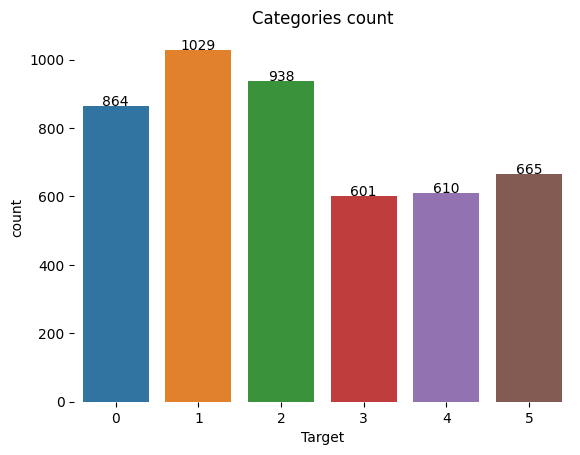

In [7]:
# Drawing label coubt
ax =sns.countplot(x='Target', data=df_copy)
plt.title('Categories count')

# Add labels to the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), '{:d}'.format(int(p.get_height())), ha='center')
# Remove spines
sns.despine(left=True, bottom=True)

plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


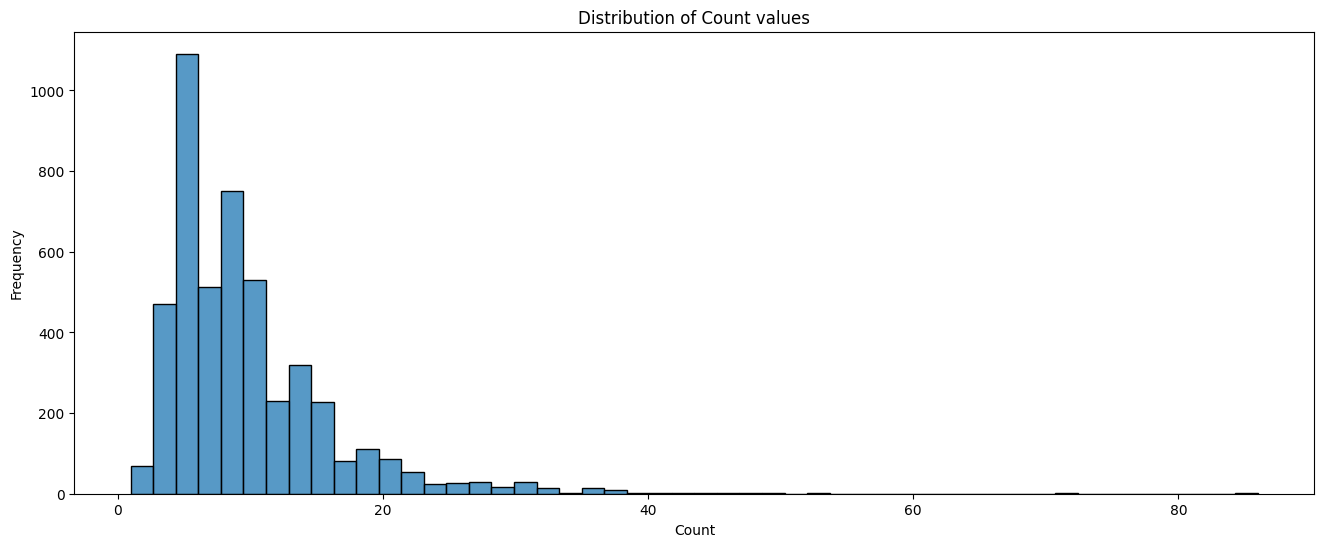

In [8]:
# Drawing count plot
plt.figure(figsize=(16, 6))
ax =sns.histplot(df_copy['Count'], bins=50, kde=False)

plt.title('Text count')

plt.title('Distribution of Count values')
plt.xlabel('Count')
plt.ylabel('Frequency')

plt.show()


In [9]:
print(df_copy[df_copy["Count"] > 80])

                                                   Text  Target  Count
3743  [अन्दिकोछोरा, पागल, केपीको, कुपुत्र, साला, चोर...       3     86


In [10]:
print(df_copy[df_copy["Count"] > 70])

                                                   Text  Target  Count
1266  [मरेर, मेराे, मेराे, देस, अर्काे, रवि, लामीछान...       0     71
3743  [अन्दिकोछोरा, पागल, केपीको, कुपुत्र, साला, चोर...       3     86
3768  [काम, लाइ, दे, चोर, तँ, लाइ, कमिसन, मिलेन, होल...       2     71


## Sequence Length
Our dataset(which is clean after stemming and stopwords, punctuations removed) has a sequence length max of 86. So the input to our models will have a max sequence length of 100 

## Dataset for torch
While we have all the binaries for fastext model, the word2vec pretrained model was only available in txt file. Thus, loading the whole model for fastext models, and text file with KeyedVectors for Word2vec

In [11]:
# Loading all the models
model_loading_paths = {
    "w2v_scratch": "/kaggle/input/word2vec/scratch/scratch.txt",
    "ft_pretrained": "/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text",
    "w2v_finetuned": "/kaggle/input/word2vec/output/finetuned.txt",
    "w2v_pretrained": "/kaggle/input/pretrained-fasttext/pretrained_word2vec/pretrained_word2vec.txt",
    "ft_scratch": "/kaggle/input/fasttext/scratch/scratch",
    "ft_finetuned": "/kaggle/input/fasttext/finetune/finetune"
}

w2v_scratch = KeyedVectors.load_word2vec_format(model_loading_paths["w2v_scratch"], binary=False)
w2v_pretrained = KeyedVectors.load_word2vec_format(model_loading_paths["w2v_pretrained"], binary=False)
w2v_finetuned = KeyedVectors.load_word2vec_format(model_loading_paths["w2v_finetuned"], binary=False)

ft_scratch = FastText.load(model_loading_paths["ft_scratch"])
ft_pretrained = FastText.load(model_loading_paths["ft_pretrained"])
ft_finetuned = FastText.load(model_loading_paths["ft_finetuned"])

# Check if loaded
print(w2v_scratch["ठोक"])
print(w2v_pretrained["ठोक"])
print(w2v_finetuned["ठोक"])
print(ft_scratch.wv["ठोक"])
print(ft_pretrained.wv["ठोक"])
print(ft_finetuned.wv["ठोक"])


[-0.11933573  0.09030999 -0.2187304  -0.15370278  0.09280358 -0.02598833
  0.17698115  0.2872062  -0.04321597  0.38296705 -0.16877079 -0.09215035
 -0.0208134   0.02383254 -0.06397777  0.04952668  0.16295172 -0.23433295
 -0.09810359 -0.10715698 -0.02549507  0.25801     0.13746937  0.3666279
  0.34576756 -0.02189754 -0.36951962  0.05139579  0.02632326  0.15817398
  0.02277323 -0.32785678 -0.20344073 -0.17002276  0.1716012  -0.00548738
  0.10803645  0.08904969 -0.00187822  0.21501237  0.20826803  0.11291107
  0.11567265  0.2987509   0.10505068 -0.04066845  0.18980324  0.21501143
  0.13320138 -0.23149629 -0.31043175 -0.14100987  0.0816247   0.00388337
  0.0941833  -0.28799045 -0.2716547   0.23490086  0.03822974  0.0897394
  0.01253599 -0.21413618 -0.06293807  0.15246612  0.1635665  -0.01072
 -0.19703706  0.03921763 -0.39029297  0.6684631  -0.14171976 -0.27515325
 -0.03610948 -0.23477875 -0.24866182  0.16911426 -0.15738429  0.12498279
 -0.15221035 -0.21222734  0.13553552 -0.32154     0.3160

### Pad token
A pad token <pad> will be concatenated to our dataset texts to reach the sequence length of max 100. This token will also be used to denoted masking of padded tokens while implementing additive attention for BiLSTM hidden State outputs

In [12]:
# Pad Token
PAD_TOKEN = "<pad>"

'''
Also adding the pad token "<pad>" to all the models,
which can also be used a word is missing and it's vectors will be zero 
'''

# In W2V models' text file
def add_pad_to_word2vec_model(model, pad_token="<pad>"):
    if pad_token not in model.key_to_index:
        model.add_vector(pad_token, np.zeros(model.vector_size))

add_pad_to_word2vec_model(w2v_scratch)
add_pad_to_word2vec_model(w2v_pretrained)
add_pad_to_word2vec_model(w2v_finetuned)

# # In FT models' binary file, building vocab due to subword vector generation in FT
# def add_pad_to_fasttext_model(model, pad_token="<pad>"):
#     if pad_token not in model.wv:
#         pad_repeated = [[PAD_TOKEN] * 10]  # Tricking fasttext model to bypass min-count threshold 
#         ft_model.build_vocab(pad_repeated, update=True)
#         model.train(pad_repeated, total_examples=1, epochs=1)
#         model.wv[pad_token] = np.zeros(model.vector_size)

# add_pad_to_fasttext_model(ft_scratch)
# add_pad_to_fasttext_model(ft_pretrained)
# add_pad_to_fasttext_model(ft_finetuned)

# Checking
print(w2v_scratch[PAD_TOKEN])
print("\n-----------\n")
print(ft_pretrained.wv[PAD_TOKEN])
    

/usr/local/lib/python3.11/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

-----------

[ 8.84222537e-02  2.59856135e-02  1.47444159e-02 -2.63834335e-02
  7.853

In [13]:
print(np.zeros(ft_pretrained.vector_size))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4707 entries, 0 to 4706
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    4707 non-null   object
 1   Target  4707 non-null   int64 
 2   Count   4707 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 110.4+ KB


### Important
Since the models with pad token "\<pad>\" is only on in-memory of this session, during inference above steps must be done when we create torch dataset with custom class below that requires these models and pad token vector.<br /> We skip on saving the model with these pad vectors as some are loaded from kaggle input and is resource heavy <br/>
For Fasttext, couldn't make zeros vector for pad token, probably because of sub word generation. So in case of fasttext, should just return zeros vector of model size when the token is pad token during embedding lookup 

### Custom class for PyTorch Dataset

In [15]:
%%writefile torch_datasets/datasets.py
import torch
import numpy as np
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, sentences, binary, model, labels=None, max_len=100, pad_token="<pad>"):
        self.sentences = sentences # Each sentence should already be tokenized, i.e sentence is a list of tokens
        self.labels = labels  # Can be None for inference
        self.model = model
        self.binary = binary # To determine if the model passed is loaded through KeyedVectors or Model.load()
        self.max_len = max_len
        self.pad_token = pad_token
        self.embed_dim = model.vector_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]

        # Pad or truncate
        padded = sentence[:self.max_len] + [self.pad_token] * (self.max_len - len(sentence))
        padded = padded[:self.max_len]

        # Mask
        mask = [1 if word != self.pad_token else 0 for word in padded]

        # Word vectors
        if self.binary:
            # Model sent as argument, i.e Fasttext
            vectors = [
                np.zeros(self.embed_dim) if word == self.pad_token else
                self.model.wv[word] if word in self.model.wv else
                np.zeros(self.embed_dim)
                for word in padded
            ]
        else:
            # KeyedVectors sent as argument for W2V also the W2V model should have embedding for "<pad>" token
            vectors = [
                self.model[word] if word in self.model else self.model[self.pad_token]
                for word in padded
            ]
            
                

        inputs = (
            torch.tensor(vectors, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.bool)
        )

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return inputs + (label,)
        else:
            return inputs

Writing torch_datasets/datasets.py


### Train, Test, Val Split
Let's make a Train, Test, Val split in the ratio of 80:10:10

In [16]:
# Stratified split into train and test+val
train_df, test_df = train_test_split(
    df_copy,
    test_size=0.2,
    stratify=df_copy["Target"],
    random_state=42
)

# Stratified split into train and val
test_df, val_df = train_test_split(
    test_df,
    test_size=0.5,
    stratify=test_df["Target"],
    random_state=42
)

print(train_df.loc[:,"Target"].value_counts())
print("\n--------------\n")
print(val_df.loc[:,"Target"].value_counts())
print("\n--------------\n")
print(test_df.loc[:,"Target"].value_counts())
print("\n--------------\n")

Target
1    823
2    750
0    691
5    532
4    488
3    481
Name: count, dtype: int64

--------------

Target
1    103
2     94
0     87
5     66
4     61
3     60
Name: count, dtype: int64

--------------

Target
1    103
2     94
0     86
5     67
4     61
3     60
Name: count, dtype: int64

--------------



### Using custom function to make pytorch dataset and saving for training usage

In [17]:
from torch_datasets.datasets import SequenceDataset

# Making dataset for three different models for both Word2Vec and Fasttext

## Word2Vec
w2v_scratch_train = SequenceDataset(train_df["Text"].tolist(), binary=False, model=w2v_scratch, labels=train_df["Target"].tolist())
w2v_scratch_test = SequenceDataset(test_df["Text"].tolist(), binary=False, model=w2v_scratch, labels=test_df["Target"].tolist())
w2v_scratch_val = SequenceDataset(val_df["Text"].tolist(), binary=False, model=w2v_scratch, labels=val_df["Target"].tolist())

w2v_pretrained_train = SequenceDataset(train_df["Text"].tolist(), binary=False, model=w2v_pretrained, labels=train_df["Target"].tolist())
w2v_pretrained_test = SequenceDataset(test_df["Text"].tolist(), binary=False, model=w2v_pretrained, labels=test_df["Target"].tolist())
w2v_pretrained_val = SequenceDataset(val_df["Text"].tolist(), binary=False, model=w2v_pretrained, labels=val_df["Target"].tolist())

w2v_finetuned_train = SequenceDataset(train_df["Text"].tolist(), binary=False, model=w2v_finetuned, labels=train_df["Target"].tolist())
w2v_finetuned_test = SequenceDataset(test_df["Text"].tolist(), binary=False, model=w2v_finetuned, labels=test_df["Target"].tolist())
w2v_finetuned_val = SequenceDataset(val_df["Text"].tolist(), binary=False, model=w2v_finetuned, labels=val_df["Target"].tolist())

## FastText
ft_scratch_train = SequenceDataset(train_df["Text"].tolist(), binary=True, model=ft_scratch, labels=train_df["Target"].tolist())
ft_scratch_test = SequenceDataset(test_df["Text"].tolist(), binary=True, model=ft_scratch, labels=test_df["Target"].tolist())
ft_scratch_val = SequenceDataset(val_df["Text"].tolist(), binary=True, model=ft_scratch, labels=val_df["Target"].tolist())

ft_pretrained_train = SequenceDataset(train_df["Text"].tolist(), binary=True, model=ft_pretrained, labels=train_df["Target"].tolist())
ft_pretrained_test = SequenceDataset(test_df["Text"].tolist(), binary=True, model=ft_pretrained, labels=test_df["Target"].tolist())
ft_pretrained_val = SequenceDataset(val_df["Text"].tolist(), binary=True, model=ft_pretrained, labels=val_df["Target"].tolist())

ft_finetuned_train = SequenceDataset(train_df["Text"].tolist(), binary=True, model=ft_finetuned, labels=train_df["Target"].tolist())
ft_finetuned_test = SequenceDataset(test_df["Text"].tolist(), binary=True, model=ft_finetuned, labels=test_df["Target"].tolist())
ft_finetuned_val = SequenceDataset(val_df["Text"].tolist(), binary=True, model=ft_finetuned, labels=val_df["Target"].tolist())

In [18]:
# Checking for success
item1 = w2v_scratch_train[0]

inputs1, masks1, label1 = item1

print(inputs1.shape)
print(inputs1)
print(masks1.shape)
print(masks1)
print(label1.shape)
print(label1)

torch.Size([100, 300])
tensor([[ 0.0769,  0.4251,  0.2578,  ...,  0.2362, -0.1652,  0.0781],
        [-0.1895,  0.1978, -0.4185,  ..., -0.0403, -0.0161,  0.0432],
        [-0.1318,  0.0543,  0.0263,  ..., -0.0983, -0.2736,  0.0574],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
torch.Size([100])
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, 

/kaggle/working/torch_datasets/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(vectors, dtype=torch.float32),


In [19]:
# Checking for success
item2 = ft_scratch_train[0]

inputs2, masks2, label2 = item2

print(inputs2.shape)
print(inputs2)
print(masks2.shape)
print(masks2)
print(label2.shape)
print(label2)

torch.Size([100, 300])
tensor([[ 0.2961, -0.1070, -0.0402,  ..., -0.2920, -0.4438, -0.2611],
        [-0.3303,  0.0642,  0.1296,  ...,  0.0172, -0.1127,  0.0676],
        [-0.1787,  0.2576,  0.1550,  ..., -0.0418, -0.2231, -0.0364],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
torch.Size([100])
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, 

In [20]:
print(len(w2v_scratch_train))
print(len(w2v_finetuned_test))
print(len(ft_finetuned_val))

3765
471
471


### saving the datasets
Above is only an example of using the custom dataset class, we cannot save the whole dataset from the output as the model used's object is too large so I'll save everything except the model object

In [21]:
torch.save({
    "sentences": train_df["Text"].tolist(),
    "labels": train_df["Target"].tolist(),
}, torch_output + "train.pt")

torch.save({
    "sentences": val_df["Text"].tolist(),
    "labels": val_df["Target"].tolist(),
}, torch_output + "val.pt")

torch.save({
    "sentences": test_df["Text"].tolist(),
    "labels": test_df["Target"].tolist(),
}, torch_output + "test.pt")

# Later for usage, as SequenceDataset class is saved
# data = torch.load(torch_output + "train.pt")
# dataset = SequenceDataset(
#     sentences=data["sentences"],
#     labels=data["labels"],
#     binary=True for fasttext False for Word2Vec,
#     model=Loaded models
# )

### huggingface datasets

In [22]:

dataset_dict = DatasetDict({
    'train': hf_ds.from_pandas(train_df),
    'validation': hf_ds.from_pandas(val_df),
    'test': hf_ds.from_pandas(test_df)
})

dataset_dict.save_to_disk(hf_output+"dataset")

Saving the dataset (0/1 shards):   0%|          | 0/3765 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/471 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/471 [00:00<?, ? examples/s]